# Introduction to Adversarial Attacks in Deep Learning

Adversarial attacks are small, intentionally crafted perturbations added to input data with the goal of misleading machine learning models. These attacks expose the vulnerabilities of even the most accurate models and are crucial for understanding model robustness and improving defenses.

In this notebook, I will experiment with several prominent adversarial attack methods:

- **FGSM (Fast Gradient Sign Method)**: A single-step attack using the gradient of the loss with respect to the input.
- **PGD (Projected Gradient Descent)**: An iterative and stronger version of FGSM.
- **DeepFool**: A minimal perturbation method that pushes the input across the decision boundary.
- **Carlini & Wagner Attack**: A powerful optimization-based attack targeting high-confidence misclassification.
- **Adversarial Patch**: A physical-world attack that applies a visible patch to any image to cause misclassification.

These experiments aim to highlight the behavior, effectiveness, and implications of each attack on neural networks.


In [13]:
# Imports for plotting
import time
import os
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pytorch_lightning as pl
import torchvision.transforms.functional as TF
from io import BytesIO
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.models import resnet34, ResNet34_Weights
from PIL import Image

DATA_DIR = 'archive/DATA'
TEST_DIR = 'archive/TEST'
LABELS_CSV = 'archive/labels.csv'

# Setting the seed
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Seed set to 42


Using device cpu


# Overview of Adversarial Attacks

Here is a short summary of the attack methods we will explore:

- **FGSM (Fast Gradient Sign Method)**: This attack generates adversarial examples by taking a single step in the direction that increases the model's loss the most. It's fast and efficient, but relatively easy to defend against.

- **PGD (Projected Gradient Descent)**: An iterative extension of FGSM that applies multiple small steps toward maximizing the loss, projecting the result back into a valid input space after each step. It's widely used to evaluate model robustness.

- **DeepFool**: This method iteratively perturbs the input just enough to cross the model’s decision boundary. It aims for minimal distortion, often producing subtle but effective adversarial examples.

- **Carlini & Wagner (C&W)**: A more advanced and powerful attack that formulates the attack as an optimization problem. It focuses on crafting perturbations that are hard to detect while ensuring high confidence in the wrong prediction.

Each of these methods showcases different strategies and strengths, helping us understand how adversaries can exploit neural networks.


In [2]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=8/255, clip_min=0.0, clip_max=1.0):
    device = imgs.device
    model.eval()
    imgs = imgs.clone().detach().requires_grad_(True)

    logits = model(imgs)
    loss = F.cross_entropy(logits, labels, reduction="sum")  # same as −log p_y

    grad = torch.autograd.grad(loss, imgs, only_inputs=True)[0]
    pert = epsilon * grad.sign()

    adv_imgs = torch.clamp(imgs + pert, clip_min, clip_max).detach()

    return adv_imgs, pert.detach()


def projected_gradient_descent(model, imgs, labels, epsilon=8/255, alpha=2/255, num_steps=10, random_start=True, clip_min=0.0, clip_max=1.0):
    device = imgs.device
    model.eval()

    # Optional random start
    if random_start:
        delta = torch.empty_like(imgs).uniform_(-epsilon, epsilon)
        adv = torch.clamp(imgs + delta, clip_min, clip_max)
    else:
        adv = imgs.clone()

    for _ in range(num_steps):
        adv = adv.detach().requires_grad_(True)

        logits = model(adv)
        loss = F.cross_entropy(logits, labels, reduction="sum")

        grad = torch.autograd.grad(loss, adv)[0]
        adv = adv + alpha * grad.sign()

        adv = torch.clamp(adv, imgs - epsilon, imgs + epsilon)
        adv = torch.clamp(adv, clip_min, clip_max)

    return adv.detach()


def carlini_wagner(model, imgs, labels, targeted=False, c_init=1e-4, c_upper=1e10, binary_search_steps=9, kappa=0.0, num_steps=1000, lr=1e-2, early_abort=True):
    device = imgs.device
    n, _, _, _ = imgs.shape
    n_classes = model(imgs[:1]).shape[1]

    # Helper
    def atanh(x): 
        return 0.5 * torch.log((1 + x) / (1 - x))

    eps = 1e-6
    imgs_clamped = imgs.clamp(eps, 1 - eps)
    w_init = atanh(imgs_clamped * 2 - 1)
    best_adv = imgs.clone()
    best_l2 = torch.full((n,), float('inf'), device=device)

    c_low = torch.zeros(n, device=device)
    c_high = torch.full((n,), c_upper, device=device)
    c = torch.full((n,), c_init, device=device)

    model.eval()

    for bs_step in range(binary_search_steps):
        w = torch.nn.Parameter(w_init.clone())
        optim = torch.optim.Adam([w], lr=lr)

        for step in range(num_steps):
            adv = torch.tanh(w) * 0.5 + 0.5
            logits = model(adv)

            one_hot = F.one_hot(labels, n_classes).float()
            real = (one_hot * logits).sum(1)
            other = ((1 - one_hot) * logits - 1e4 * one_hot).max(1).values

            if targeted:
                f = torch.clamp(other - real + kappa, min=0.)
            else:
                f = torch.clamp(real - other + kappa, min=0.)

            l2 = (adv - imgs_clamped).view(n, -1).pow(2).sum(1)
            loss = (c * f + l2).sum()

            optim.zero_grad()
            loss.backward()
            optim.step()

            # Track best successful adv
            with torch.no_grad():
                mask = (f == 0) & (l2 < best_l2)
                best_l2[mask] = l2[mask]
                best_adv[mask] = adv[mask]

            if early_abort and (f == 0).all():
                break

        # Update c via binary search
        succeeded = best_l2 < float('inf')
        c_high[succeeded] = torch.min(c_high[succeeded], c[succeeded])
        c_low[~succeeded] = torch.max(c_low[~succeeded], c[~succeeded])
        c = torch.where(c_high < 1e9, (c_low + c_high) / 2, c * 10)

    perturb = best_adv - imgs
    return best_adv.detach(), perturb.detach()


def deepfool(model, imgs, num_steps=50, overshoot=0.02, max_classes=10):
    device = imgs.device
    model.eval()

    with torch.no_grad():
        orig_labels = model(imgs).argmax(1)

    adv = imgs.clone().detach()
    perturb = torch.zeros_like(adv)
    batch, _ = imgs.shape[:2]

    for _ in range(num_steps):
        adv.requires_grad_(True)
        logits = model(adv)
        preds  = logits.argmax(1)

        # stop if every sample changed label
        if (preds != orig_labels).all():
            break

        grad_list = []
        for idx in range(batch):
            if preds[idx] != orig_labels[idx]:
                grad_list.append(torch.zeros_like(adv[idx])) # already fooled
                continue

            # Select strongest `max_classes` logits to cut work
            topk = torch.topk(logits[idx], max_classes).indices
            grads = []
            for k in topk:
                grad = torch.autograd.grad(logits[idx, k], adv, retain_graph=True, create_graph=False)[0][idx]
                grads.append(grad)

            k0 = preds[idx].item()
            grad0 = grads[topk.tolist().index(k0)]
            min_ratio, best_r = float("inf"), None

            for g, k in zip(grads, topk):
                if k == k0: continue
                w_k = g - grad0
                f_k = logits[idx, k] - logits[idx, k0]
                ratio = f_k.abs() / (w_k.flatten().norm() + 1e-12)
                if ratio < min_ratio:
                    min_ratio, best_r = ratio, w_k

            r_i = best_r / best_r.flatten().norm() * min_ratio
            perturb[idx] += r_i
            adv.data[idx] = imgs[idx] + (1 + overshoot) * perturb[idx]

        adv = torch.clamp(adv.detach(), 0.0, 1.0)

    adv_final = torch.clamp(imgs + (1 + overshoot) * perturb, 0.0, 1.0)
    return adv_final.detach(), (adv_final - imgs).detach()


# Model Description

For my experiments, I use a **ResNet-34** convolutional neural network, provided by pytorch, a well-known architecture that incorporates residual connections to train deeper networks effectively. I trained the model on a dataset of **traffic signs**, enabling it to recognize and classify various road signs with high accuracy.

This setup provides a realistic scenario to evaluate adversarial attacks, as traffic sign recognition is a critical task in safety-sensitive applications like autonomous driving. By testing different attacks on this model, we can analyze how adversarial examples might compromise real-world systems.


In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 8
LEARNING_RATE = 0.001
NUM_WORKERS = 8


print('Setting up data transformations...')
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


print('Loading datasets...')
train_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
# This part is sensetive to the dataset folder structure. Replace with your own if needed.

# Sort folder names numerically
sorted_classes = sorted(train_dataset.classes, key=lambda x: int(x))
# Remap class_to_idx to match integer folder names
train_dataset.class_to_idx = {cls_name: int(cls_name) for cls_name in sorted_classes}
train_dataset.classes = sorted_classes  # optional, for consistency

test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_dataset.class_to_idx = {cls_name: int(cls_name) for cls_name in sorted(test_dataset.classes, key=lambda x: int(x))}
test_dataset.classes = sorted(test_dataset.classes, key=lambda x: int(x))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of validation samples: {len(test_dataset)}')
print(f'Number of classes: {len(train_dataset.classes)}')


print('Loading ResNet34 model...')
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


print('Starting training...')

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    start_time = time.time()

    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            print(f'[Batch {batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}')

    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] Training Loss: {avg_loss:.4f}')

    print('Starting validation...')
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] Validation Accuracy: {accuracy:.2f}%')

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] completed in {elapsed_time:.2f} seconds')

print('Saving the model...')
torch.save(model.state_dict(), 'models/resnet34_custom_fixed.pth')
print('Model saved to models/resnet34_custom_fixed.pth ✅')


# Correct Prediction Example

The following example demonstrates a correctly classified traffic sign by the ResNet-34 model. This confirms that the model performs as expected on clean, unperturbed input data. It has overall 87% of accuracy


In [5]:
def predict_image(img, model, transform, id_to_name, top_k=5, device='cpu'):
    model.eval()
    input_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        top_probs_tensor, top_indices_tensor = torch.topk(probs, top_k, dim=1)

        returned_top_probs = top_probs_tensor.squeeze(0).cpu().numpy()
        returned_top_indices = top_indices_tensor.squeeze(0).cpu().numpy()

    print(f'Top {len(returned_top_probs)} predictions (from predict_image):')
    for i in range(len(returned_top_probs)):
        class_idx = int(returned_top_indices[i])
        class_name = id_to_name.get(class_idx, f'Class {class_idx}')
        prob = returned_top_probs[i]
        print(f'  {i+1}: {class_name} ({prob*100:.2f}%)')
    return returned_top_probs, returned_top_indices

Loading model...
Loading image archive/TEST/0/000_1_0005_1_j.png...
Making prediction using predict_image function...
Top 5 predictions (from predict_image):
  1: Speed limit (5km/h) (94.89%)
  2: Speed limit (15km/h) (3.84%)
  3: Danger Ahead (0.53%)
  4: No horn (0.40%)
  5: Unknown7 (0.07%)


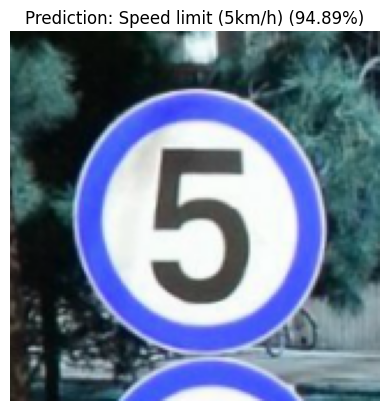

In [8]:
MODEL_PATH = 'models/resnet34_custom_fixed_1epochs.pth' # Path to your trained model
IMAGE_PATH = 'archive/TEST/0/000_1_0005_1_j.png'
TOP_K = 5 # Show top 5 predictions


labels_df = pd.read_csv(LABELS_CSV)
id_to_name = dict(zip(labels_df['ClassId'], labels_df['Name']))


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

print('Loading model...')
model = resnet34(weights=None)
num_classes = len(id_to_name)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()


print(f'Loading image {IMAGE_PATH}...')
image = Image.open(IMAGE_PATH).convert('RGB')
print('Making prediction using predict_image function...')
top_probs_np, top_indices_np = predict_image(image, model, transform, id_to_name, top_k=TOP_K, device=device)

plt.imshow(image)
plt.axis('off')
# Use the values returned by predict_image for the plot title
predicted_class = id_to_name.get(int(top_indices_np[0]), 'Unknown')
plt.title(f'Prediction: {predicted_class} ({top_probs_np[0]*100:.2f}%)')
plt.show()


# Robustness to Random Perturbations

In this example, I apply **random noise** and **JPEG compression** to the original image to test the model's robustness to common, non-adversarial distortions.

As expected, these random modifications do not significantly affect the model's prediction. This demonstrates that standard perturbations—unlike carefully crafted adversarial ones—do not typically mislead the model, highlighting the targeted nature of adversarial attacks.



Predictions with random noise:
Top 5 predictions (from predict_image):
  1: Speed limit (5km/h) (93.32%)
  2: Speed limit (15km/h) (4.73%)
  3: Danger Ahead (0.79%)
  4: No horn (0.59%)
  5: Unknown7 (0.13%)

Predictions with JPEG compression (quality=30):
Top 5 predictions (from predict_image):
  1: Speed limit (5km/h) (94.38%)
  2: Speed limit (15km/h) (4.23%)
  3: Danger Ahead (0.59%)
  4: No horn (0.43%)
  5: Unknown7 (0.08%)


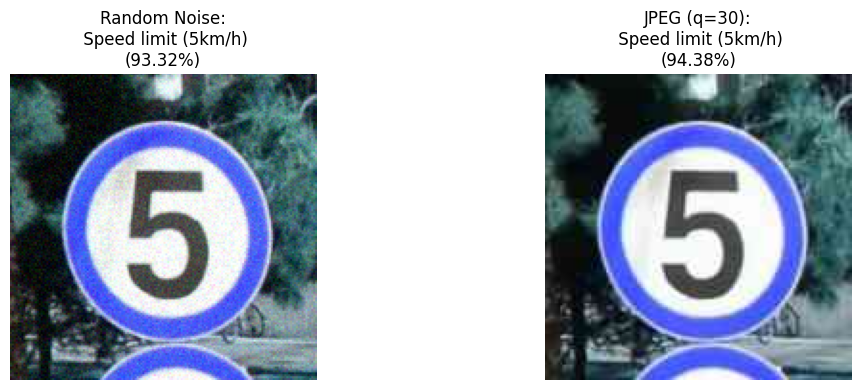

In [12]:
# Load original image
img = Image.open(IMAGE_PATH).convert('RGB')

# Add random noise
img_np = np.array(img).astype(np.float32) / 255.0
noise = np.random.normal(0, 0.05, img_np.shape)
img_noisy = np.clip(img_np + noise, 0, 1)
img_noisy_pil = Image.fromarray((img_noisy * 255).astype(np.uint8))
print("\nPredictions with random noise:")
predict_image(img_noisy_pil, model, transform, id_to_name, top_k=TOP_K, device=device)

buffer = BytesIO()
img.save(buffer, format='JPEG', quality=30)
buffer.seek(0)
img_jpeg = Image.open(buffer)
print("\nPredictions with JPEG compression (quality=30):")
predict_image(img_jpeg, model, transform, id_to_name, top_k=TOP_K, device=device)
# Set subplot titles to model predictions
def get_pred_title(img):
    input_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        top_prob, top_idx = torch.max(probs, dim=1)
        class_name = id_to_name.get(int(top_idx.item()), f'Class {top_idx.item()}')
        return f"{class_name}\n({top_prob.item()*100:.2f}%)"

# Show all three images side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(img_noisy_pil)
axs[0].set_title(f"Random Noise:\n {get_pred_title(img_noisy_pil)}")
axs[0].axis('off')

axs[1].imshow(img_jpeg)
axs[1].set_title(f"JPEG (q=30):\n {get_pred_title(img_jpeg)}")
axs[1].axis('off')

plt.tight_layout()
plt.show()


# Adversarial Attack Results

Below, I show the effect of different adversarial attacks on a correctly classified traffic sign. Each attack modifies the original image just enough to deceive the model, causing it to misclassify the sign with varying confidence levels.

- **FGSM** leads to a correct classification as "Speed limit (5km/h)" but with much lower confidence, and the top-5 predictions are close variations of speed limit signs.
- **PGD** is significantly more aggressive, confidently misclassifying the image as "Go Right" with 98.28% confidence—completely unrelated to the original class.
- **CW (Carlini & Wagner)** and **DeepFool** produce more subtle perturbations, both leading to a misclassification as "Speed limit (40km/h)", which is a plausible mistake, but still incorrect.

These results highlight how even imperceptible changes can fool the model, and how the type of attack affects both the confidence and nature of the misclassification.


FGSM Adversarial top predictions:
  1: Speed limit (5km/h) (27.31%)
  2: Speed limit (15km/h) (22.78%)
  3: Speed limit (40km/h) (16.85%)
  4: Danger Ahead (4.20%)
  5: No horn (3.99%)

PGD Adversarial top predictions:
  1: Go Right (98.28%)
  2: Bicycles crossing (0.57%)
  3: Unknown5 (0.36%)
  4: Go straight (0.22%)
  5: Dont Go Left or Right (0.21%)

CW Adversarial top predictions:
  1: Speed limit (40km/h) (29.53%)
  2: Speed limit (15km/h) (28.25%)
  3: Speed limit (5km/h) (21.97%)
  4: No horn (3.96%)
  5: Speed limit (60km/h) (3.25%)

DeepFool Adversarial top predictions:
  1: Speed limit (40km/h) (33.05%)
  2: Speed limit (5km/h) (33.05%)
  3: Speed limit (15km/h) (16.90%)
  4: No horn (3.55%)
  5: Speed limit (60km/h) (1.91%)


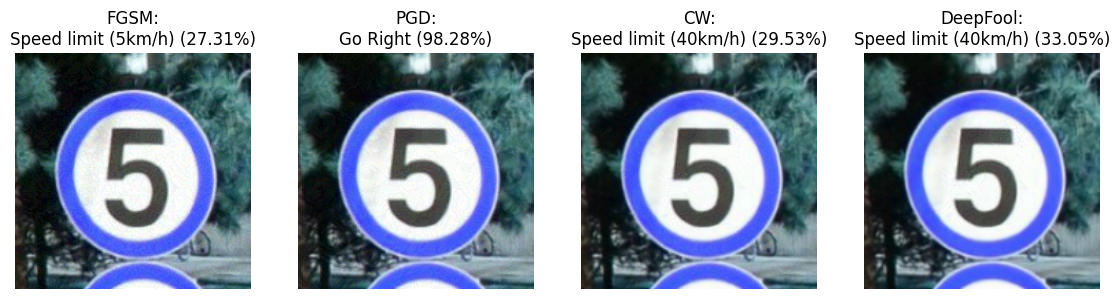

In [56]:
# Load and preprocess the image (reuse IMAGE_PATH, transform, device)
img = Image.open(IMAGE_PATH).convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# Get the true label if available, otherwise pick the top-1 prediction as label
with torch.no_grad():
    output = model(img_tensor)
    pred_label = output.argmax(dim=1)

# FGSM attack
adv_img_fgsm, _ = fast_gradient_sign_method(model, img_tensor, pred_label, epsilon=0.02)

# PGD attack
adv_img_pgd = projected_gradient_descent(model, img_tensor, pred_label, epsilon=0.02, alpha=0.01, num_steps=10)

# Carlini-Wagner attack
adv_img_cw, _ = carlini_wagner(model, img_tensor, pred_label, targeted=False, kappa=0.0, num_steps=200, lr=5e-2)

# DeepFool attack
adv_img_deepfool, _ = deepfool(model, img_tensor, num_steps=20, overshoot=0.02)

# Get predictions for the adversarial images
def get_topk_preds(img_adv):
    with torch.no_grad():
        adv_output = model(img_adv)
        adv_probs = torch.softmax(adv_output, dim=1)
        adv_top_probs, adv_top_indices = torch.topk(adv_probs, TOP_K)
        adv_top_probs = adv_top_probs.squeeze().cpu().numpy()
        adv_top_indices = adv_top_indices.squeeze().cpu().numpy()
    return adv_top_probs, adv_top_indices

adv_top_probs_fgsm, adv_top_indices_fgsm = get_topk_preds(adv_img_fgsm)
adv_top_probs_pgd, adv_top_indices_pgd = get_topk_preds(adv_img_pgd)
adv_top_probs_cw, adv_top_indices_cw = get_topk_preds(adv_img_cw)
adv_top_probs_deepfool, adv_top_indices_deepfool = get_topk_preds(adv_img_deepfool)

print('FGSM Adversarial top predictions:')
for i in range(TOP_K):
    class_idx = int(adv_top_indices_fgsm[i])
    class_name = id_to_name.get(class_idx, f'Class {class_idx}')
    prob = adv_top_probs_fgsm[i]
    print(f'  {i+1}: {class_name} ({prob*100:.2f}%)')

print('\nPGD Adversarial top predictions:')
for i in range(TOP_K):
    class_idx = int(adv_top_indices_pgd[i])
    class_name = id_to_name.get(class_idx, f'Class {class_idx}')
    prob = adv_top_probs_pgd[i]
    print(f'  {i+1}: {class_name} ({prob*100:.2f}%)')

print('\nCW Adversarial top predictions:')
for i in range(TOP_K):
    class_idx = int(adv_top_indices_cw[i])
    class_name = id_to_name.get(class_idx, f'Class {class_idx}')
    prob = adv_top_probs_cw[i]
    print(f'  {i+1}: {class_name} ({prob*100:.2f}%)')

print('\nDeepFool Adversarial top predictions:')
for i in range(TOP_K):
    class_idx = int(adv_top_indices_deepfool[i])
    class_name = id_to_name.get(class_idx, f'Class {class_idx}')
    prob = adv_top_probs_deepfool[i]
    print(f'  {i+1}: {class_name} ({prob*100:.2f}%)')

# Visualize images
fig, axs = plt.subplots(1, 4, figsize=(14, 4))

# Original prediction
with torch.no_grad():
    orig_probs = torch.softmax(output, dim=1)
    orig_top_prob, orig_top_idx = torch.max(orig_probs, dim=1)
    orig_class_name = id_to_name.get(int(orig_top_idx.item()), f'Class {orig_top_idx.item()}')
    orig_prob = orig_top_prob.item()

# FGSM adversarial image
adv_class_name_fgsm = id_to_name.get(int(adv_top_indices_fgsm[0]), f'Class {adv_top_indices_fgsm[0]}')
adv_prob_fgsm = adv_top_probs_fgsm[0]
adv_img_disp_fgsm = adv_img_fgsm.squeeze().detach().cpu().permute(1, 2, 0).numpy().clip(0, 1)
axs[0].imshow(adv_img_disp_fgsm)
axs[0].set_title(f'FGSM:\n{adv_class_name_fgsm} ({adv_prob_fgsm*100:.2f}%)')
axs[0].axis('off')

# PGD adversarial image
adv_class_name_pgd = id_to_name.get(int(adv_top_indices_pgd[0]), f'Class {adv_top_indices_pgd[0]}')
adv_prob_pgd = adv_top_probs_pgd[0]
adv_img_disp_pgd = adv_img_pgd.squeeze().detach().cpu().permute(1, 2, 0).numpy().clip(0, 1)
axs[1].imshow(adv_img_disp_pgd)
axs[1].set_title(f'PGD:\n{adv_class_name_pgd} ({adv_prob_pgd*100:.2f}%)')
axs[1].axis('off')

# CW adversarial image
adv_class_name_cw = id_to_name.get(int(adv_top_indices_cw[0]), f'Class {adv_top_indices_cw[0]}')
adv_prob_cw = adv_top_probs_cw[0]
adv_img_disp_cw = adv_img_cw.squeeze().detach().cpu().permute(1, 2, 0).numpy().clip(0, 1)
axs[2].imshow(adv_img_disp_cw)
axs[2].set_title(f'CW:\n{adv_class_name_cw} ({adv_prob_cw*100:.2f}%)')
axs[2].axis('off')

# DeepFool adversarial image
adv_class_name_deepfool = id_to_name.get(int(adv_top_indices_deepfool[0]), f'Class {adv_top_indices_deepfool[0]}')
adv_prob_deepfool = adv_top_probs_deepfool[0]
adv_img_disp_deepfool = adv_img_deepfool.squeeze().detach().cpu().permute(1, 2, 0).numpy().clip(0, 1)
axs[3].imshow(adv_img_disp_deepfool)
axs[3].set_title(f'DeepFool:\n{adv_class_name_deepfool} ({adv_prob_deepfool*100:.2f}%)')
axs[3].axis('off')

plt.show()

# Generating an Adversarial Patch

In this section, I generate an **adversarial patch**—a localized and visible perturbation designed to be overlaid onto any input image. Unlike other attacks that apply subtle noise across the entire image, patch attacks aim to create a universal and transferable trigger that causes misclassification regardless of the image content or context.

The code below optimizes the patch using the model's gradients to maximize the prediction confidence for a specific target class. Once trained, this patch can be applied to different images to consistently fool the model into making incorrect predictions.


In [ ]:
def generate_adversarial_patch(model, dataloader, target_class, patch_size=(50, 50), image_size=(224, 224), num_epochs=20, batch_size_patch_opt=16,
    learning_rate=0.01,
    max_rotation_angle=15.0,
    scale_range=(0.1, 0.3),
    device=None,
    verbose=True
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval() # Set the model to evaluation mode
    for param in model.parameters():
        param.requires_grad = False # Freeze model parameters

    patch = torch.rand(1, 3, patch_size[0], patch_size[1], device=device, requires_grad=True)
    optimizer = optim.Adam([patch], lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    if verbose:
        print(f"Starting adversarial patch generation on {device}...")
        print(f"Target class: {target_class}, Patch size: {patch_size}, Image size: {image_size}")
        print(f"Epochs: {num_epochs}, LR: {learning_rate}, Batch size for patch opt: {batch_size_patch_opt}")

    for epoch in range(num_epochs):
        running_loss = 0.0
        batches_processed = 0
        for i, (images, _) in enumerate(dataloader):
            if images.shape[0] == 0:
                continue

            current_batch_size = min(images.shape[0], batch_size_patch_opt)
            if images.shape[0] < batch_size_patch_opt and verbose and i==0 and epoch==0:
                print(f"Warning: Dataloader batch size ({images.shape[0]}) is less than "
                      f"batch_size_patch_opt ({batch_size_patch_opt}). "
                      "Patch gradients will be averaged over smaller batches.")


            images_subset = images[:current_batch_size].to(device)
            patched_images_for_batch = []

            for img_idx in range(images_subset.shape[0]):
                original_image = images_subset[img_idx:img_idx+1].clone()
                
                scale_factor = random.uniform(scale_range[0], scale_range[1])
                scaled_patch_height = int(image_size[0] * scale_factor)
                # Maintain aspect ratio of the initial patch_size for scaling
                scaled_patch_width = int(patch_size[1] * (scaled_patch_height / patch_size[0])) 
                if scaled_patch_height <=0 or scaled_patch_width <=0: # Safety check
                    scaled_patch_height = max(1, scaled_patch_height)
                    scaled_patch_width = max(1, scaled_patch_width)

                current_patch_scaled = TF.resize(patch, (scaled_patch_height, scaled_patch_width), antialias=True)
                angle = random.uniform(-max_rotation_angle, max_rotation_angle)
                
                rotated_patch = TF.rotate(current_patch_scaled, angle, fill=0.0, expand=False) 
                patch_mask = torch.ones_like(rotated_patch, device=device)

                # Random location
                max_y = image_size[0] - rotated_patch.shape[2] # height
                max_x = image_size[1] - rotated_patch.shape[3] # width
                
                loc_y = random.randint(0, max(0, max_y))
                loc_x = random.randint(0, max(0, max_x))

                patched_image = original_image.clone()
                
                # Define the region in the image
                # Ensure slices don't go out of bounds
                end_y = loc_y + rotated_patch.shape[2]
                end_x = loc_x + rotated_patch.shape[3]
                
                # Simple overlay:
                patched_image[0, :, loc_y:end_y, loc_x:end_x] = rotated_patch[0]
                
                patched_images_for_batch.append(patched_image)

            if not patched_images_for_batch:
                continue

            patched_images_tensor = torch.cat(patched_images_for_batch, dim=0).to(device)
            
            optimizer.zero_grad()
            outputs = model(patched_images_tensor)
            target_labels = torch.full((patched_images_tensor.shape[0],), target_class,
                                       dtype=torch.long, device=device)
            loss = criterion(outputs, target_labels)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                patch.data.clamp_(0.0, 1.0)

            running_loss += loss.item()
            batches_processed +=1
            
            if verbose and (i % 10 == 0 or i == len(dataloader) - 1):
                 print(f"  [Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(dataloader)}] Current Batch Loss: {loss.item():.4f}")
        
        if batches_processed > 0:
            avg_epoch_loss = running_loss / batches_processed
            if verbose:
                print(f"Epoch {epoch+1}/{num_epochs} - Average Patch Loss: {avg_epoch_loss:.4f}")
        else:
            if verbose:
                print(f"Epoch {epoch+1}/{num_epochs} - No batches processed in this epoch.")

    if verbose:
        print("Adversarial patch generation finished.")
    return patch.detach()


DATA_DIR_FOR_PATCH_GEN = "archive/DATA"
MODEL_PATH = "models/resnet34_custom_fixed_1epochs.pth"
TARGET_CLASS_IDX = 14 # Choose a valid class index from your dataset
OUTPUT_PATCH_FILENAME = "generated_adversarial_patch.png"
USER_BATCH_SIZE = 32 # Batch size for loading background images
USER_NUM_WORKERS = 8
PATCH_SIZE_HW = (50, 50) # Size of the patch to be generated
MODEL_IMG_SIZE_HW = (224, 224) # Image size your model expects
NUM_PATCH_EPOCHS = 1 # Number of epochs to train the patch
PATCH_OPT_BATCH_SIZE = 16 # Number of images from dataloader to use for each patch update step. Ensure USER_BATCH_SIZE >= PATCH_OPT_BATCH_SIZE is reasonable or handle appropriately
PATCH_LR = 0.01


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
background_image_transform = transforms.Compose([
    transforms.Resize(MODEL_IMG_SIZE_HW),
    transforms.ToTensor(),
])

if not os.path.isdir(DATA_DIR_FOR_PATCH_GEN):
    print(f"Error: DATA_DIR_FOR_PATCH_GEN '{DATA_DIR_FOR_PATCH_GEN}' not found. Please set the correct path.")
    exit()

print(f"Loading background images from: {DATA_DIR_FOR_PATCH_GEN}")
background_dataset = datasets.ImageFolder(DATA_DIR_FOR_PATCH_GEN, transform=background_image_transform)

try:
    sorted_classes_bg = sorted(background_dataset.classes, key=lambda x: int(x))
    background_dataset.class_to_idx = {cls_name: int(cls_name) for cls_name in sorted_classes_bg}
    background_dataset.classes = sorted_classes_bg
    print(f"Background dataset classes (sorted and re-indexed): {background_dataset.classes}")
except ValueError:
    print("Warning: Could not sort background dataset classes numerically. Using default ImageFolder ordering.")
    print(f"Background dataset classes: {background_dataset.classes}")


background_loader = DataLoader(background_dataset, batch_size=USER_BATCH_SIZE, shuffle=True, num_workers=USER_NUM_WORKERS)

num_available_classes = len(background_dataset.classes)
print(f"Number of classes in background dataset: {num_available_classes}")

if not (0 <= TARGET_CLASS_IDX < num_available_classes):
    print(f"Error: TARGET_CLASS_IDX {TARGET_CLASS_IDX} is out of range for {num_available_classes} classes.")
    exit()

print(f"Loading model: {MODEL_PATH}")
if not os.path.exists(MODEL_PATH):
    print(f"Error: Model path '{MODEL_PATH}' not found. Please set the correct path.")
    exit()
    
model_to_attack = resnet34(weights=None)
model_to_attack.fc = nn.Linear(model_to_attack.fc.in_features, num_available_classes)

try:
    model_to_attack.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print("Model state loaded successfully.")
except Exception as e:
    print(f"Error loading model state_dict: {e}")
    print("Ensure num_classes used for model.fc matches the saved model.")
    exit()
    
model_to_attack = model_to_attack.to(device)
model_to_attack.eval() # Ensure model is in eval mode

print("\nStarting adversarial patch generation process...")
start_patch_time = time.time()

adversarial_patch = generate_adversarial_patch(
    model=model_to_attack,
    dataloader=background_loader,
    target_class=TARGET_CLASS_IDX,
    patch_size=PATCH_SIZE_HW,
    image_size=MODEL_IMG_SIZE_HW,
    num_epochs=NUM_PATCH_EPOCHS,
    batch_size_patch_opt=PATCH_OPT_BATCH_SIZE,
    learning_rate=PATCH_LR,
    device=device,
    verbose=True
)
end_patch_time = time.time()
print(f"Adversarial patch generation took {end_patch_time - start_patch_time:.2f} seconds.")

if adversarial_patch is not None:
    print(f"\nAdversarial patch generated successfully (shape: {adversarial_patch.shape}).")
    try:
        save_image(adversarial_patch.squeeze(0).cpu(), OUTPUT_PATCH_FILENAME)
        print(f"Saved generated patch to '{OUTPUT_PATCH_FILENAME}'")
    except ImportError:
        print("torchvision.utils.save_image not available. Cannot save patch image.")
    except Exception as e:
        print(f"Error saving patch image: {e}")
else:
    print("Adversarial patch generation failed.")

Using device: cpu
Loading background images from: archive/DATA
Background dataset classes (sorted and re-indexed): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51']
Number of classes in background dataset: 52
Loading model: models/resnet34_custom_fixed_1epochs.pth
Model state loaded successfully.

Starting adversarial patch generation process...
Starting adversarial patch generation on cpu...
Target class: 14, Patch size: (50, 50), Image size: (224, 224)
Epochs: 1, LR: 0.01, Batch size for patch opt: 16
  [Epoch 1/1, Batch 1/178] Current Batch Loss: 13.0107
  [Epoch 1/1, Batch 11/178] Current Batch Loss: 11.6180
  [Epoch 1/1, Batch 21/178] Current Batch Loss: 10.8343
  [Epoch 1/1, Batch 31/178] Current Batch Loss: 11.5900
  [Epoch 1/1, B

# Applying the Adversarial Patch

To demonstrate the effect of the adversarial patch, we randomly place it on the input image. While more advanced techniques may optimize the patch's location, this simple approach already reveals its effectiveness.

Despite the randomness, the patch often causes the model to misclassify the image with high confidence, highlighting the robustness and transferability of the attack.

In [169]:
def add_patch_to_image(image_path, patch, patch_size=32):
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0

    if isinstance(patch, torch.Tensor):
        patch_disp = (torch.tanh(patch) + 1) / 2 if patch.min() < 0 or patch.max() > 1 else patch
        patch_disp = patch_disp.detach().cpu().permute(1, 2, 0).numpy()
        patch_disp = np.clip(patch_disp, 0, 1)
    else:
        patch_disp = patch

    if isinstance(patch_disp, np.ndarray):
        h_patch, w_patch = patch_disp.shape[:2]
    elif isinstance(patch_disp, Image.Image):
        w_patch, h_patch = patch_disp.size
        patch_disp = np.array(patch_disp).astype(np.float32) / 255.0
    else:
        raise TypeError("patch_disp must be a numpy array or PIL Image.")

    if h_patch != patch_size or w_patch != patch_size:
        patch_disp = np.array(Image.fromarray((patch_disp * 255).astype(np.uint8)).resize((patch_size, patch_size)))
        patch_disp = patch_disp.astype(np.float32) / 255.0

    h, w, _ = img_np.shape
    if h - patch_size > 0:
        y1 = np.random.randint(0, h - patch_size + 1)
    else:
        y1 = 0
    if w - patch_size > 0:
        x1 = np.random.randint(0, w - patch_size + 1)
    else:
        x1 = 0
    y2 = y1 + patch_size
    x2 = x1 + patch_size
    y2 = min(y2, h)
    x2 = min(x2, w)
    img_np[y1:y2, x1:x2, :] = patch_disp[:y2 - y1, :x2 - x1, :]

    # Convert back to PIL Image for display or saving
    img_with_patch = Image.fromarray((img_np * 255).astype(np.uint8))

    return img_with_patch


image_path = "archive/TEST/1/001_0006_j.png"  # Replace with your image path
patch_path = "generated_adversarial_patch.png"  # Replace with your patch path
patch = Image.open(patch_path).convert('RGB')
patched_img = add_patch_to_image(image_path, patch, patch_size=50)
patched_img.show()

patched_img.save("patched_output.jpg")

# Prediction with Adversarial Patch vs. Black Patch

In this section, I evaluate the impact of the adversarial patch on the model's prediction. When the patch is applied to the image, the model is successfully fooled and misclassifies the input with high confidence—demonstrating the attack's effectiveness.

To further validate that the misclassification is not simply due to occasion, we replace the adversarial patch with a **black (non-informative) patch** at the exact same location. The model still correctly classifies the image in this case, confirming that the adversarial patch's structure—not just its presence—is responsible for misleading the model.

This comparison illustrates how adversarial patches can hijack the model’s attention and produce targeted misclassifications, even when applied randomly and visibly.


Loading image patched_output.jpg...
Top predictions for adversarial patch:
  1: Under Construction (60.27%)
  2: Speed limit (15km/h) (32.49%)
  3: Speed limit (60km/h) (6.24%)
  4: Speed limit (50km/h) (0.54%)
  5: Danger Ahead (0.15%)

Top predictions for fake patch:
  1: Speed limit (15km/h) (88.58%)
  2: Danger Ahead (6.13%)
  3: Under Construction (3.58%)
  4: Dont Go Left or Right (0.71%)
  5: Speed limit (5km/h) (0.48%)


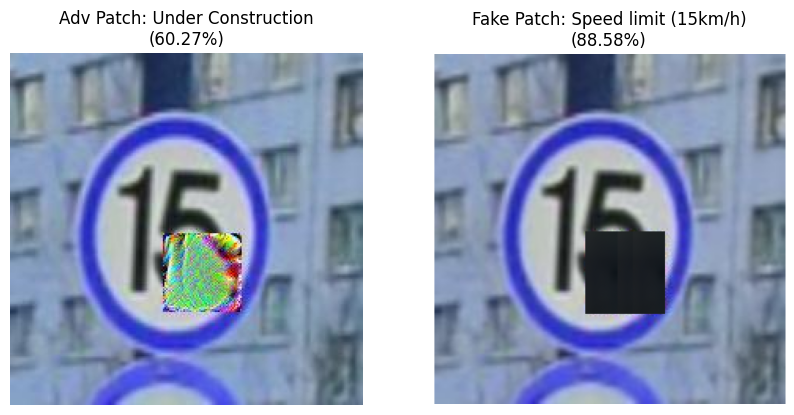

In [174]:
MODEL_PATH = 'models/resnet34_custom_fixed_1epochs.pth' # Path to your trained model
IMAGE_PATH = 'patched_output.jpg'
FAKE_PATCH_PATH = 'fake_patch.png'

print(f'Loading image {IMAGE_PATH}...')
image = Image.open(IMAGE_PATH).convert('RGB')
fake_patch_image = Image.open(FAKE_PATCH_PATH).convert('RGB')

# Preprocess both images
input_tensor = transform(image).unsqueeze(0).to(device)
fake_patch_tensor = transform(fake_patch_image).unsqueeze(0).to(device)

# Get predictions for both images
with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    top_probs, top_indices = torch.topk(probabilities, TOP_K)
    top_probs = top_probs.squeeze().cpu().numpy()
    top_indices = top_indices.squeeze().cpu().numpy()

    outputs_fake = model(fake_patch_tensor)
    probabilities_fake = torch.softmax(outputs_fake, dim=1)
    top_probs_fake, top_indices_fake = torch.topk(probabilities_fake, TOP_K)
    top_probs_fake = top_probs_fake.squeeze().cpu().numpy()
    top_indices_fake = top_indices_fake.squeeze().cpu().numpy()

print('Top predictions for adversarial patch:')
for i in range(TOP_K):
    class_idx = int(top_indices[i])
    class_name = id_to_name.get(class_idx, f'Class {class_idx}')
    prob = top_probs[i]
    print(f'  {i+1}: {class_name} ({prob*100:.2f}%)')

print('\nTop predictions for fake patch:')
for i in range(TOP_K):
    class_idx = int(top_indices_fake[i])
    class_name = id_to_name.get(class_idx, f'Class {class_idx}')
    prob = top_probs_fake[i]
    print(f'  {i+1}: {class_name} ({prob*100:.2f}%)')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].axis('off')
predicted_class = id_to_name.get(int(top_indices[0]), 'Unknown')
axs[0].set_title(f'Adv Patch: {predicted_class}\n({top_probs[0]*100:.2f}%)')

axs[1].imshow(fake_patch_image)
axs[1].axis('off')
predicted_class_fake = id_to_name.get(int(top_indices_fake[0]), 'Unknown')
axs[1].set_title(f'Fake Patch: {predicted_class_fake}\n({top_probs_fake[0]*100:.2f}%)')

plt.show()